# Multi-Step Forecasting (Real Power Load): Recursive vs Direct vs Multi-Output

This notebook compares three multi-step strategies on *real hourly power load + temperature*:

- **Recursive (Iterated):** train one 1-step model and **iterate** it forward.
- **Direct:** train one **separate** model for each horizon $h = 1, \dots, H$.
- **Multi-Output:** train **one** model to predict the full horizon vector at once.

**Baselines:** Naïve and Seasonal-Naïve.
**Metrics:** MAE, RMSE, and **Skill vs. baselines**

$$
\text{Skill}(h) \;=\; 1 - \frac{\text{Error}_{\text{model}}(h)}{\text{Error}_{\text{baseline}}(h)}
$$

---

## Data & setup
- **Data:** Mid-Atlantic hourly **demand (MW)** and **temperature (°C)** (loaded from GitHub).
- **Split:** strict **chronological** split (train/test) to avoid leakage.
- **Horizon:** default $H = 24$ (next 24 hours).

---

## Evaluation protocol
- Report **MAE(h)** and **RMSE(h)** for $h = 1, \dots, H$.
- Compare against **Naïve** and **Seasonal-Naïve** baselines:

$$
\hat{y}_{t+1}^{\text{naive}} = y_t,
\qquad
\hat{y}_{t+1}^{\text{seasonal}} = y_{t+1-s}, \;\; s=\text{season period}
$$

- Plot **Skill vs. Naïve** as a function of $h$.

---

## Important caveats (time-series!)
- **No random shuffles** across time — always respect order.
- **Feature alignment matters:** when iterating recursively, rebuild features (lags, seasonal terms, exogenous covariates) **exactly** as the model expects.
- **Exogenous variables:** if you use them in training (e.g. temperature), you must provide a consistent **future proxy** at inference (e.g. seasonal-naïve forecast or a separate temperature model).

In [1]:
# Core scientific libraries
import numpy as np                  # numerical arrays and math
import pandas as pd                 # tabular data handling (time series as DataFrames)
import matplotlib.pyplot as plt     # plotting library

# Model: we use Ridge regression (linear model with L2 regularization)
from sklearn.linear_model import Ridge

# -----------------------------
# Reproducibility
# -----------------------------
# Create a reproducible random number generator (NumPy style)
rng = np.random.default_rng(42)
# Also set the global NumPy seed for functions that don’t take rng explicitly
np.random.seed(42)

# -----------------------------
# Matplotlib defaults
# -----------------------------
# Make figures a bit larger (9x4 inches) for better readability
plt.rcParams['figure.figsize'] = (9, 4)
# Show grid lines by default in plots (helps in reading time series)
plt.rcParams['axes.grid'] = True

## 1) Load data (Mid-Atlantic hourly load + temperature)

We will use a real dataset of **hourly electricity demand** (in MW) and **temperature** (in °C) for the Mid-Atlantic region.
This dataset contains both the **target variable** (demand) and an **exogenous regressor** (temperature), which we can use to improve forecasting.

- **Target:**
  $$
  y_t = \text{demand at hour } t \; (\text{in MW})
  $$

- **Exogenous input:**
  $$
  u_t = \text{temperature at hour } t \; (^\circ \text{C})
  $$

We will:
1. Load the data directly from GitHub in CSV format.
2. Parse the `datetime` column into a proper time index.
3. Keep only the two relevant columns: `demand` and `temp`.
4. Drop any missing values to ensure clean input for modeling.

This gives us a clean DataFrame:

$$
\{\, (t, y_t, u_t) \,\}_{t=1}^T
$$

which we will use to build lag features and evaluate forecasting strategies.

In [2]:
# URL of the CSV file hosted on GitHub (Mid-Atlantic hourly demand + temperature)
RAW_URL = "https://raw.githubusercontent.com/vmpreciado/ESE538/main/midatlantic_august2024_combined.csv"

# Load the CSV into a DataFrame:
# - parse the 'datetime' column into actual datetime objects
# - set 'datetime' as the index
# - sort the index to ensure chronological order
df = pd.read_csv(RAW_URL, parse_dates=['datetime']).set_index('datetime').sort_index()

# Keep only the two columns we need:
#   - rename 'total_power_load_MW' -> 'demand'
#   - rename 'temperature_C' -> 'temp'
#   - drop any rows with missing values
data = df.rename(columns={
    'total_power_load_MW': 'demand',
    'temperature_C': 'temp'
})[['demand', 'temp']].dropna()

# Preview the first 5 rows of the cleaned DataFrame
print(data.head())

# Print dataset size and the time range covered
print("Rows:", len(data), " Range:", data.index.min(), "->", data.index.max())

                      demand  temp
datetime                          
2024-08-01 00:00:00  2421894  22.9
2024-08-01 01:00:00  2322910  22.9
2024-08-01 02:00:00  2415240  22.8
2024-08-01 03:00:00  2236486  23.8
2024-08-01 04:00:00  1056416  23.8
Rows: 744  Range: 2024-08-01 00:00:00 -> 2024-08-31 23:00:00


## 2) Feature construction (lags + seasonal sin/cos + optional temp)

To train forecasting models, we must turn the raw time series into **supervised learning features**.
At each time step $t$, we create a **feature vector** $\boldsymbol{\phi}_t$ that summarizes useful past information:

- **Lag features (autoregression):**
  Include the last $L$ observed demands:
  $$
  \{ y_{t-1}, y_{t-2}, \dots, y_{t-L} \}
  $$
  These capture short-term temporal dependencies.

- **Seasonal indicators:**
  Encode the **hour-of-day cycle** using sine and cosine functions:
  $$
  \sin\!\Big(\tfrac{2\pi t}{s}\Big), \quad
  \cos\!\Big(\tfrac{2\pi t}{s}\Big)
  $$
  where $s=24$ for daily seasonality (hours).
  These allow linear models to represent periodic behavior.

- **Exogenous temperature (optional):**
  Include the temperature at time $t$, $u_t$, and a 24-hour moving average:
  $$
  u_t, \qquad \tfrac{1}{24}\sum_{k=1}^{24} u_{t-k}
  $$
  Demand is strongly affected by temperature, so this helps the model adjust to weather conditions.

---

### Feature vector summary
At each time $t$, the feature vector is:
$$
\boldsymbol{\phi}_t
=
\Big[
y_{t-1}, \dots, y_{t-L}, \;
\sin\!\big(\tfrac{2\pi t}{s}\big),\;
\cos\!\big(\tfrac{2\pi t}{s}\big),\;
u_t,\;\tfrac{1}{24}\sum_{k=1}^{24} u_{t-k}
\Big]
$$

These features will be paired with the **target** $y_t$ (the demand at time $t$), so that we can fit models to map:
$$
\boldsymbol{\phi}_t \;\mapsto\; y_t
$$

This setup transforms the time-series forecasting problem into a **regression task** that standard machine learning models can handle.

In [4]:
# -----------------------------
# Feature engineering settings
# -----------------------------
USE_TEMP = True        # whether to include temperature covariates or not
LAGS     = 48          # number of lag features (48 hours = 2 days of history)
SEASON   = 24          # period for daily seasonality (24 hours)

def make_features_from_series(df, lags=LAGS, season_period=SEASON, use_temp=True):
    """
    Construct supervised learning features from a time series DataFrame.

    Inputs:
      df: DataFrame with columns ['demand', 'temp'] indexed by datetime
      lags: number of demand lags to include as features
      season_period: period (in hours) for sinusoidal seasonality
      use_temp: whether to include temperature covariates

    Returns:
      idx : array of time indices corresponding to constructed rows
      X   : feature matrix (n_samples x n_features)
      y_out : target vector (demand at current time)
    """
    y = df['demand'].values   # demand series (target variable)
    if use_temp:
        temp = df['temp'].values   # temperature series (exogenous covariate)

    rows = []   # will collect tuples (time index, feature vector, target)
    # start from 'lags' because we need past 'lags' demand values to build features
    for t in range(lags, len(y)):
        feats = []

        # -----------------------------
        # 1) Lag features of demand
        # -----------------------------
        # add y_{t-1}, y_{t-2}, ..., y_{t-lags}
        feats.extend([y[t-k] for k in range(1, lags+1)])

        # -----------------------------
        # 2) Seasonal basis functions
        # -----------------------------
        # encode hour-of-day cycle with sine/cosine at period = season_period
        feats.append(np.sin(2*np.pi * t / season_period))
        feats.append(np.cos(2*np.pi * t / season_period))

        # -----------------------------
        # 3) Exogenous temperature features (optional)
        # -----------------------------
        if use_temp:
            # temperature at current time t
            feats.append(temp[t])
            # 24-hour moving average of temperature (or shorter avg if early in series)
            if t >= 24:
                feats.append(temp[t-24:t].mean())
            else:
                feats.append(temp[max(0, t-6):t].mean())  # use 6-hour avg if not enough history

        # target at time t is the actual demand y[t]
        rows.append((t, np.array(feats), y[t]))

    # unpack rows into separate arrays
    idx, X_list, y_list = zip(*rows)
    X = np.vstack(X_list)          # feature matrix
    y_out = np.array(y_list)       # target vector
    return np.array(idx), X, y_out

# -----------------------------
# Build features on the dataset
# -----------------------------
idx, X, y = make_features_from_series(
    data,
    lags=LAGS,
    season_period=SEASON,
    use_temp=USE_TEMP
)

# Quick check: first 5 indices, feature matrix shape, target shape
(idx[:5].tolist(), X.shape, y.shape)

([48, 49, 50, 51, 52], (696, 52), (696,))

## 3) Train / Test split and forecast horizon

Once we have transformed the raw series into supervised learning pairs
$(\boldsymbol{\phi}_t, y_t)$, we need to **split** the dataset into a training portion
and a testing portion.

- **Chronological split:**
  In time series, we must respect temporal order.
  The model is trained on the **earlier portion** (train set) and evaluated on the **later portion** (test set).
  Random shuffles (as in cross-sectional ML) would cause *data leakage*.

- **Forecast horizon $H$:**
  Instead of predicting only the next step ($h=1$), we are interested in forecasting
  the next $H$ hours ahead:
  $$
  \widehat{y}_{t+1}, \;\widehat{y}_{t+2}, \;\dots,\;\widehat{y}_{t+H}
  $$
  with $H = 24$ (the next 24 hours).

- **Evaluation by horizon:**
  We will compute metrics (MAE, RMSE, Skill) separately for each step $h = 1,\dots,H$.
  This lets us compare **short-term accuracy** vs. **long-term accuracy**, and analyze how
  errors accumulate across different strategies.

---

**Summary:**
- Use the first 80% of the series as **train** and the last 20% as **test**.
- Define forecast horizon $H = 24$.
- Later, we will evaluate model predictions $\{\widehat{y}_{t+h}\}$ against true values
  $\{y_{t+h}\}$ for each horizon $h$.

In [5]:
# -----------------------------
# Forecast horizon
# -----------------------------
H = 24   # We want to forecast the next 24 hours (1 full day ahead)

# -----------------------------
# Chronological train/test split
# -----------------------------
# Use the first 80% of the time series for training,
# and reserve the last 20% for testing (strict chronological split, no shuffling).
split = int(0.8 * len(idx))

# Split the feature matrix X into training and testing parts
X_train, X_test = X[:split], X[split:]

# Split the target vector y (demand) into training and testing parts
y_train, y_test = y[:split], y[split:]

# Also split the indices (time stamps) for reference
idx_train, idx_test = idx[:split], idx[split:]

# -----------------------------
# Quick check:
# - number of training samples
# - number of test samples
# - forecast horizon length
# -----------------------------
len(y_train), len(y_test), H

(556, 140, 24)

## 4) Baselines (Naive, Seasonal-Naive with guard)

Before comparing advanced forecasting strategies, it is essential to establish **baseline models**.
These serve as simple reference points: a good forecasting model should **at least** outperform them.

---

### 1. Naïve baseline
The naïve method assumes that the next value will be the same as the most recent observation:
$$
\hat{y}_{t+1}^{\text{naive}} = y_t
$$
For multi-step forecasting ($H>1$), this logic is extended recursively:
$$
\hat{y}_{t+h}^{\text{naive}} = y_t, \qquad h=1,\dots,H
$$
In other words, the forecast is a **flat line** equal to the last observed demand.

---

### 2. Seasonal Naïve baseline
The seasonal naïve method assumes that the series repeats itself every season (here, one day = 24 hours):
$$
\hat{y}_{t+1}^{\text{seasonal}} = y_{t+1-s}, \qquad s = 24
$$
For multi-step horizons, the forecast copies the values from the same time(s) of the previous day:
$$
\hat{y}_{t+h}^{\text{seasonal}} = y_{t+h-s}, \qquad h=1,\dots,H
$$
This captures strong **daily patterns** in electricity demand (e.g., peaks and troughs repeating each day).

---

### Guard against insufficient history
At the very beginning of the series, we might not have enough seasonal history (e.g., fewer than $s=24$ points).
In that case, we **fall back to the naïve forecast** for those early points to avoid indexing errors.

---

**Why baselines matter:**
- Provide a **minimum benchmark**: if a sophisticated model cannot beat seasonal naïve, it is not useful.
- Help interpret **Skill scores**:
  $$
  \text{Skill}(h) = 1 - \frac{\text{Error}_{\text{model}}(h)}{\text{Error}_{\text{baseline}}(h)}.
  $$
  Positive Skill means the model improves on the baseline, while negative Skill means it performs worse.

In [6]:
def forecast_naive_path(y_hist, H):
    """
    Naïve baseline forecaster:
    - Forecast horizon: H
    - Rule: all future values equal to the last observed value y_t.

    Input:
      y_hist : array of past observations up to current time t
      H      : forecast horizon

    Output:
      path   : array of length H, where each forecast ŷ_{t+h} = y_t
    """
    # Fill an array of length H with the last observed demand
    return np.full(H, y_hist[-1])


def forecast_seasonal_naive_path(y_hist, H, s):
    """
    Seasonal naïve baseline forecaster:
    - Forecast horizon: H
    - Rule: repeat the value from the same season period ago (e.g., yesterday).

    Input:
      y_hist : array of past observations up to current time t
      H      : forecast horizon
      s      : season length (e.g., 24 hours for daily seasonality)

    Output:
      path   : array of length H, where each forecast ŷ_{t+h} = y_{t+h-s}
               (fallback to naïve if not enough seasonal history is available)
    """
    # Guard: if history is shorter than one season, fall back to naive forecast
    if len(y_hist) < s:
        return forecast_naive_path(y_hist, H)

    path = []
    for h in range(1, H+1):
        # Index in the past season relative to current history length
        idx = -s + h - 1
        if idx < 0:
            # Use seasonal value from y_hist
            val = y_hist[idx]
        else:
            # If we run out of true seasonal values, reuse from already-built path
            val = path[idx]     # equivalent to repeating season pattern
        path.append(val)
    return np.array(path)


def build_rolling_targets(y_series, H):
    """
    Construct rolling H-step targets from a series.

    For each starting index i, build the sequence:
        [y_{i+1}, y_{i+2}, ..., y_{i+H}]
    which represents the ground-truth future path of length H.

    Input:
      y_series : array of observed values (train or test portion)
      H        : forecast horizon

    Output:
      Y : array of shape (n_paths, H)
          Each row corresponds to one forecast path target.
    """
    Y = []
    for i in range(len(y_series) - H):
        Y.append(y_series[i+1:i+1+H])
    return np.array(Y)


# Build rolling H-step ground truth sequences for evaluation
Y_test_true  = build_rolling_targets(y_test, H)
Y_train_true = build_rolling_targets(y_train, H)

# Quick check of test target shape: (n_paths, H)
Y_test_true.shape

(116, 24)

## 5) Three strategies

We now implement and compare the three classic strategies for **multi-step forecasting**.

---

### 5.1 Recursive (Iterated)

**Idea:**
- Train a **single 1-step-ahead model** to predict $y_{t+1}$ from features at time $t$:
  $$
  \widehat{y}_{t+1} = f_{\theta}(\boldsymbol{\phi}_t)
  $$
- To forecast multiple steps ahead, **feed predictions back** into the model as if they were true values.

**Procedure (for horizon $H$):**
1. Train $f_\theta$ using pairs $(\boldsymbol{\phi}_t, y_{t+1})$.
2. Given history up to time $t$, forecast one step ahead:
   $$
   \widehat{y}_{t+1} = f_\theta(\boldsymbol{\phi}_t)
   $$
3. Update the feature vector $\boldsymbol{\phi}_{t+1}$ by inserting $\widehat{y}_{t+1}$ in place of the true $y_{t+1}$.
4. Repeat recursively to generate:
   $$
   \widehat{y}_{t+2}, \;\widehat{y}_{t+3}, \;\dots,\;\widehat{y}_{t+H}
   $$

---

**Advantages:**
- Only one model needs to be trained.
- Efficient when $H$ is large.

**Drawbacks:**
- **Error accumulation:** prediction errors at earlier horizons are carried forward and amplified at later horizons.
- Performance often degrades as $h$ increases.

---

In code, this means:
- Train a 1-step Ridge regression model.
- At test time, iteratively rebuild the feature vector using predicted values in place of actual ones.

In [9]:
# ------------------------------------------------------------
# Raw series aligned with the original datetime index (absolute time)
# ------------------------------------------------------------
demand_full = data['demand'].values   # full demand series
temp_full   = data['temp'].values     # full temperature series

def recursive_forecast_paths(
    X_test,
    demand_full,              # raw demand (NOT the feature-aligned y)
    idx_full,                 # absolute time indices corresponding to rows in X
    split_idx,                # where test starts in idx_full
    H,                        # forecast horizon
    model,                    # one-step model (trained on 1-step features)
    lags,                     # number of lag features used in training
    season_period,            # seasonal period (e.g., 24 hours)
    use_temp=True,
    temp_full=None            # raw temperature aligned with original index
):
    """
    Build H-step forecast paths by iteratively applying a 1-step model.

    Key idea:
      - At test time, we "roll forward" from each test start.
      - At each step, we reconstruct the SAME feature vector used during training:
          [y_{t-1}, ..., y_{t-lags}] + [sin(2πt/s), cos(2πt/s)] + (temp_t, temp_ma_24) if used
      - For future timesteps, we:
          * use previous predictions for the lagged demand slots,
          * use a seasonal-naïve proxy for temperature: T_{t+h} := T_{t+h-season_period}.

    Important:
      We index demand_full/temp_full with ABSOLUTE time indices (idx_full), not the
      feature-aligned arrays, to avoid off-by-one / out-of-range errors.
    """
    if use_temp and temp_full is None:
        raise ValueError("temp_full must be provided when use_temp=True")

    paths = []

    # ------------------------------------------------------------
    # Guard the number of recursive starts so we do not run off the end
    # of the raw series when rolling H steps ahead.
    # ------------------------------------------------------------
    first_abs    = idx_full[split_idx]                 # abs. time index of first test row
    max_k_by_X   = len(X_test) - H                     # limited by how many test rows we have
    max_k_by_abs = (len(demand_full) - 1) - H - first_abs
    N_paths      = max(0, min(max_k_by_X, max_k_by_abs))

    for k in range(N_paths):
        # Absolute time index at which this forecast path begins
        t_idx = idx_full[split_idx + k]

        # -----------------------------
        # Demand history: last 'lags' values at absolute times (oldest -> newest)
        # -----------------------------
        dem_hist = [demand_full[t_idx - j] for j in range(1, lags + 1)][::-1]

        # -----------------------------
        # Temperature history: last up to 24 hours (for temp moving average)
        # -----------------------------
        if use_temp:
            last_24  = min(24, t_idx + 1)
            temp_hist = [temp_full[t_idx - j] for j in range(last_24)][::-1]
            # If the series is extremely short, ensure we have at least one value
            if len(temp_hist) == 0:
                temp_hist = [temp_full[max(0, t_idx)]]

        preds = []              # store the H-step forecasts for this path
        cur_t = t_idx           # advance absolute time as we roll forward

        for h in range(1, H + 1):
            cur_t += 1

            # -----------------------------
            # Seasonal basis at absolute time cur_t
            # -----------------------------
            season_feats = [
                np.sin(2 * np.pi * cur_t / season_period),
                np.cos(2 * np.pi * cur_t / season_period),
            ]

            # -----------------------------
            # Temperature features (optional)
            # Seasonal-naïve proxy: T_{t+h} = T_{t+h - season_period}
            # Then compute 24h MA from the updated temp history.
            # -----------------------------
            temp_feats = []
            if use_temp:
                if (cur_t - season_period) >= 0:
                    temp_next = temp_full[cur_t - season_period]
                else:
                    # If not enough history, persist last seen temperature
                    temp_next = temp_hist[-1]
                temp_hist.append(temp_next)

                if len(temp_hist) >= 24:
                    temp_ma = float(np.mean(temp_hist[-24:]))
                else:
                    temp_ma = float(np.mean(temp_hist))

                temp_feats = [temp_next, temp_ma]

            # -----------------------------
            # Assemble the feature vector in EXACT training order:
            # [lags ...] + [sin, cos] + [temp_0, temp_ma_24] (if used)
            # -----------------------------
            x_list = dem_hist[-lags:] + season_feats + temp_feats
            x_cur  = np.array(x_list, dtype=float).reshape(1, -1)

            # One-step prediction at cur_t
            yhat1 = model.predict(x_cur)[0]
            preds.append(yhat1)

            # Append predicted demand so next step's lag window uses it
            dem_hist.append(yhat1)

        # Store the full H-step path for this start
        paths.append(np.array(preds))

    return np.array(paths)

# ------------------------------------------------------------
# Call after defining the function (section 5.1 Recursive)
# ------------------------------------------------------------
# 1) Train the 1-step model on the training features
one_step = Ridge(alpha=1.0).fit(X_train, y_train)

# Sanity check: the recursive feature builder must match the training feature count
print("n_features (train) =", X_train.shape[1])

Y_rec = recursive_forecast_paths(
    X_test,
    demand_full=demand_full,   # raw demand, not feature-aligned y
    idx_full=idx,
    split_idx=split,
    H=H,
    model=one_step,            # <-- now defined
    lags=LAGS,
    season_period=SEASON,
    use_temp=USE_TEMP,
    temp_full=temp_full
)

n_features (train) = 52


### 5.2 Direct

**Idea (horizon-specific models).**
Instead of iterating a 1-step model, the **Direct** strategy fits **one model per horizon** $h=1,\dots,H$.
Each model learns to predict the target at a **fixed lead time** directly from features at time $t$:

$$
\widehat{y}_{t+h} \;=\; f_{\theta_h}\!\big(\boldsymbol{\phi}_t\big),
\qquad h=1,\dots,H.
$$

---

**Training targets (alignment).**
For each $h$, build pairs $\big(\boldsymbol{\phi}_t,\; y_{t+h}\big)$ and fit $f_{\theta_h}$ on that aligned dataset:

$$
\theta_h^\star
\;=\;
\arg\min_{\theta_h}\;
\frac{1}{N_h}\sum_{t}\,\mathcal{L}\!\Big(
y_{t+h},\; f_{\theta_h}(\boldsymbol{\phi}_t)
\Big),
\qquad h=1,\dots,H,
$$

where $\mathcal{L}$ is a regression loss (e.g., squared error), and $N_h$ is the number of valid training pairs for horizon $h$.

---

**Forecasting (test time).**
Given $\boldsymbol{\phi}_t$, produce the full $H$-step path **in one shot** by evaluating all horizon-specific models:

$$
\big(\widehat{y}_{t+1},\dots,\widehat{y}_{t+H}\big)
\;=\;
\big(f_{\theta_1}(\boldsymbol{\phi}_t),\;\dots,\; f_{\theta_H}(\boldsymbol{\phi}_t)\big).
$$

---

**Advantages**
- **No error accumulation:** predictions at $t+h$ do **not** depend on earlier $\widehat{y}_{t+k}$.
- **Horizon specialization:** each $f_{\theta_h}$ can capture dynamics specific to lead time $h$ (e.g., diurnal effects or mean-reversion at longer horizons).
- **Parallelizable:** training and inference per $h$ can be done in parallel.

**Drawbacks**
- **Computational cost:** need to train $H$ separate models.
- **Data fragmentation:** each horizon sees fewer effective samples; variance can increase for large $h$.
- **Hyperparameter tuning:** must be shared (for simplicity) or tuned per $h$ (more costly).

---

**Practical notes**
- **Feature alignment:** for each $h$, pair $\boldsymbol{\phi}_t$ with $y_{t+h}$ (no leakage; strict chronology).
- **Exogenous variables:** $\boldsymbol{\phi}_t$ may include temperature and calendar features at time $t$.
  Unlike Recursive, Direct does **not** need exogenous forecasts at $t+h$ because it conditions only on $t$.
- **Fair comparisons:** use the **same feature set** across horizons unless you have strong reasons to differ.
- **Relation to Multi-Output:** Direct is like a **decoupled** version of multi-output; it may lose cross-horizon coherence, but gains flexibility.

---

*In code, we loop over $h=1,\dots,H$: for each horizon, shift the target by $h$ steps, fit a model on $(X_h, y_h)$, and at test time evaluate all $H$ models on the same $\boldsymbol{\phi}_t$.*

In [10]:
# ------------------------------------------------------------
# DIRECT STRATEGY: one model per horizon h = 1..H
# ------------------------------------------------------------
direct_models = []
for h in range(1, H+1):
    # -----------------------------
    # Align the horizon-h target with the current feature rows:
    #  - Features at time t: X[t]  (built from y_{t-1},...,y_{t-LAGS}, etc.)
    #  - Target at time t:  y_{t+h}
    # Because y and X were created starting at index LAGS, we shift y by +h
    # and drop the last h rows of X so (X_h[t], y_h[t]) are aligned.
    # -----------------------------
    y_h = y[LAGS + h:]   # targets y_{t+h} aligned with X rows starting at index 0
    X_h = X[:-h]         # drop the last h feature rows to match y_h length

    # Chronological split for horizon h
    X_h_train, X_h_test = X_h[:split],  X_h[split:]
    y_h_train, y_h_test = y_h[:split],  y_h[split:]

    # Train a separate 1-step model for this specific horizon h
    m = Ridge(alpha=1.0).fit(X_h_train, y_h_train)
    direct_models.append(m)

# ------------------------------------------------------------
# Build H-step forecast paths for each test start using the H models
# ------------------------------------------------------------
paths_direct = []
N_paths = len(X_test) - H   # number of test starts for which a full H-step path is available
for k in range(N_paths):
    # Evaluate ALL horizon-specific models on the SAME feature row X_test[k]
    # This yields the full path (ŷ_{t+1}, ..., ŷ_{t+H}) in one shot
    preds = [
        direct_models[h-1].predict(X_test[k].reshape(1, -1))[0]
        for h in range(1, H+1)
    ]
    paths_direct.append(np.array(preds))

# Stack into a (N_paths, H) array
Y_dir = np.array(paths_direct)
Y_dir.shape

(116, 24)

### 5.3 Multi-Output

**Idea (one model for all horizons).**
Instead of training one model per horizon (Direct) or reusing a 1-step model recursively (Iterated),
the **Multi-Output** strategy trains **a single model** that predicts the entire $H$-step vector in one shot:

$$
\big(\widehat{y}_{t+1}, \dots, \widehat{y}_{t+H}\big)
\;=\;
f_{\theta}\!\big(\boldsymbol{\phi}_t\big).
$$

---

**Training formulation.**
We build input–output pairs of the form:
$$
\Big(\,\boldsymbol{\phi}_t,\; [y_{t+1},\,y_{t+2},\,\dots,\,y_{t+H}]\,\Big),
$$
and fit a single model $f_\theta$ with a vector-valued output.
The loss function aggregates errors across horizons:
$$
\theta^\star = \arg\min_\theta \frac{1}{N}\sum_{t}\sum_{h=1}^H
\mathcal{L}\!\Big(y_{t+h},\; [f_\theta(\boldsymbol{\phi}_t)]_h\Big),
$$
where $[f_\theta(\boldsymbol{\phi}_t)]_h$ denotes the $h$-th coordinate of the model’s output vector.

---

**Forecasting (test time).**
Given $\boldsymbol{\phi}_t$, the model directly outputs the full horizon forecast:
$$
\widehat{\mathbf{y}}^{(t)} =
\big(\widehat{y}_{t+1},\,\widehat{y}_{t+2},\,\dots,\,\widehat{y}_{t+H}\big).
$$

---

**Advantages**
- **Single model:** only one training step, simpler pipeline.
- **Cross-horizon coherence:** predictions for different horizons are learned jointly, which can improve consistency of the forecast path.
- **Parallel efficiency:** prediction of the full horizon is immediate (no loops).

**Drawbacks**
- **Model complexity:** output dimension grows with $H$.
- **Data-hungry:** requires more training data to reliably fit all horizons simultaneously.
- **Less specialization:** may underperform if dynamics differ strongly across horizons.

---

**Practical notes**
- Often used with **multi-output regression models** (e.g. linear Ridge with vector outputs, neural networks).
- Can outperform Recursive (no error accumulation) and Direct (captures horizon dependencies),
  but may be less robust when sample size is small.
- A good compromise when you want **consistent $H$-step trajectories** with one model instead of many.

---

*In code, we align the training set so that each feature vector $\boldsymbol{\phi}_t$ is paired with its next $H$ true values as a row target. Then we fit one model $f_\theta$ that outputs $H$ numbers at once.*

In [11]:
# ------------------------------------------------------------
# MULTI-OUTPUT STRATEGY: one model that predicts all H horizons at once
# ------------------------------------------------------------

# Build rolling H-step target sequences from the training set
# Each row is [y_{t+1}, y_{t+2}, ..., y_{t+H}]
Y_train_targets = build_rolling_targets(y_train, H=H)

# Align the feature matrix X_train with Y_train_targets:
#  - Only keep as many rows of X_train as there are valid H-step targets
#  - This ensures (X_train_mo[i], Y_train_targets[i]) are aligned in time
X_train_mo = X_train[:len(Y_train_targets)]

# Similarly align the test set:
#  - We already have Y_test_true from earlier
#  - Keep the same number of rows in X_test
X_test_mo  = X_test[:len(Y_test_true)]

# Train a single Ridge regression model with multi-output targets
# Ridge can handle a vector-valued y, so it learns to map φ_t -> [y_{t+1}, ..., y_{t+H}]
mo_model = Ridge(alpha=1.0).fit(X_train_mo, Y_train_targets)

# Predict full H-step forecast paths for the test set
Y_mo = mo_model.predict(X_test_mo)

# The result is an array of shape (n_test_paths, H),
# where each row is a multi-output forecast path
Y_mo.shape

(116, 24)

## 6) Evaluation (MAE, RMSE, Skill vs baselines)

Once we have produced multi-step forecasts using the three strategies
(Recursive, Direct, Multi-Output) and the baselines (Naïve, Seasonal-Naïve),
we need to **quantify forecast accuracy**.

We will evaluate forecasts **horizon by horizon**:
for each $h = 1,\dots,H$, compute errors between predicted values
$\widehat{y}_{t+h}$ and true values $y_{t+h}$ across all test paths.

---

### Error metrics

1. **Mean Absolute Error (MAE):**
   $$
   \text{MAE}(h) \;=\; \frac{1}{N}\sum_{t=1}^N \big|\,y_{t+h} - \widehat{y}_{t+h}\,\big|
   $$
   - Easy to interpret (average error in MW).
   - Robust to outliers compared to squared error.

2. **Root Mean Squared Error (RMSE):**
   $$
   \text{RMSE}(h) \;=\;
   \sqrt{ \frac{1}{N}\sum_{t=1}^N \big(y_{t+h} - \widehat{y}_{t+h}\big)^2 }
   $$
   - Penalizes **large errors** more strongly than MAE.
   - Useful when large deviations are particularly costly.

---

### Skill score (relative to a baseline)

To assess whether a forecasting method improves upon a simple baseline (Naïve or Seasonal-Naïve),
we compute the **Skill score**:

$$
\text{Skill}(h) \;=\; 1 \;-\;
\frac{\text{Error}_{\text{model}}(h)}{\text{Error}_{\text{baseline}}(h)}
$$

- If $\text{Skill}(h) > 0$: the model outperforms the baseline at horizon $h$.
- If $\text{Skill}(h) = 0$: the model is equivalent to the baseline.
- If $\text{Skill}(h) < 0$: the model performs worse than the baseline.

We will compute Skill using **MAE** as the error measure.

---

### Why evaluate horizon by horizon?

- Short-term forecasts ($h=1,2,3$) are usually more accurate.
- Recursive models typically **degrade** with increasing $h$ (error accumulation).
- Direct and Multi-Output strategies may capture **longer-term structure** better.
- Horizon-wise evaluation lets us visualize these trade-offs clearly.

In [12]:
def metrics_by_horizon(Y_true, Y_pred):
    """
    Compute horizon-wise MAE and RMSE between Y_true and Y_pred.

    Y_true : array (n_paths, H)
    Y_pred : array (n_paths, H)

    - Trims to the minimum number of valid paths to ensure equal lengths.
    - Returns arrays of length H with MAE(h) and RMSE(h).
    """
    # Align to common number of rows (starts) in case arrays differ slightly
    N = min(Y_true.shape[0], Y_pred.shape[0])
    Yt = Y_true[:N]
    Yp = Y_pred[:N]
    H = Yt.shape[1]

    mae, rmse = [], []
    for h in range(H):
        e = Yt[:, h] - Yp[:, h]        # errors at horizon h
        mae.append(np.mean(np.abs(e))) # MAE(h)
        rmse.append(np.sqrt(np.mean(e**2)))  # RMSE(h)
    return np.array(mae), np.array(rmse)


def build_baseline_paths(y_hist, H, season_period):
    """
    Generate rolling Naive and Seasonal-Naive forecast paths over y_hist.

    - For each possible start in y_hist, build an H-step forecast path.
    - Returns two arrays: (naive_paths, seasonal_paths), each shape (n_paths, H).
    """
    paths_naive, paths_seas = [], []
    for i in range(len(y_hist) - H):
        hist = y_hist[:i+1]  # history up to current point
        p1 = forecast_naive_path(hist, H)
        p2 = forecast_seasonal_naive_path(hist, H, s=season_period)
        paths_naive.append(p1)
        paths_seas.append(p2)
    return np.array(paths_naive), np.array(paths_seas)


# Build baselines once on the test portion of the data
Y_naive, Y_seas = build_baseline_paths(y_test, H, SEASON)


def skill(f_err, b_err):
    """
    Compute Skill score relative to a baseline error:
        Skill = 1 - (forecast_error / baseline_error)
    """
    return 1.0 - f_err / b_err


def align_paths(*Ys):
    """
    Align multiple forecast/target arrays to the same number of rows (paths).
    - Finds the minimum number of starts across all arrays.
    - Truncates each to that length to prevent shape mismatches.
    """
    N = min(Y.shape[0] for Y in Ys)
    return tuple(Y[:N] for Y in Ys)


def metrics_and_skill(Y_true, Y_pred, Y_baseline):
    """
    Compute horizon-wise MAE, RMSE, and Skill vs a baseline.

    - Aligns Y_true, Y_pred, Y_baseline to the same number of paths.
    - Computes forecast error vs true and baseline error vs true.
    - Skill(h) = 1 - MAE_forecast(h) / MAE_baseline(h).
    """
    Yt, Yp, Yb = align_paths(Y_true, Y_pred, Y_baseline)
    H = Yt.shape[1]

    mae, rmse, skill_vals = [], [], []
    for h in range(H):
        e_f = Yt[:, h] - Yp[:, h]      # forecast errors
        e_b = Yt[:, h] - Yb[:, h]      # baseline errors

        f_mae = np.mean(np.abs(e_f))
        b_mae = np.mean(np.abs(e_b))

        mae.append(f_mae)
        rmse.append(np.sqrt(np.mean(e_f**2)))
        skill_vals.append(1 - f_mae / b_mae)
    return np.array(mae), np.array(rmse), np.array(skill_vals)


# ------------------------------------------------------------
# Compute metrics for each strategy vs the Naive baseline
# ------------------------------------------------------------
mae_rec, rmse_rec, skill_rec_nv = metrics_and_skill(Y_test_true, Y_rec, Y_naive)
mae_dir, rmse_dir, skill_dir_nv = metrics_and_skill(Y_test_true, Y_dir, Y_naive)
mae_mo,  rmse_mo,  skill_mo_nv  = metrics_and_skill(Y_test_true, Y_mo,  Y_naive)

# Baseline-only metrics: align before computing
Yt_nv, Ynv = align_paths(Y_test_true, Y_naive)
mae_nv, rmse_nv = metrics_by_horizon(Yt_nv, Ynv)

Yt_sn, Ysn = align_paths(Y_test_true, Y_seas)
mae_sn, rmse_sn = metrics_by_horizon(Yt_sn, Ysn)

# ------------------------------------------------------------
# Put results into DataFrames for easier plotting
# ------------------------------------------------------------
mae_df = pd.DataFrame({
    "h": np.arange(1, H+1),
    "Recursive": mae_rec,
    "Direct": mae_dir,
    "Multi-Output": mae_mo,
    "Naive": mae_nv,
    "Seasonal-Naive": mae_sn
})

skill_df = pd.DataFrame({
    "h": np.arange(1, H+1),
    "Skill vs Naive (Recursive)": skill_rec_nv,
    "Skill vs Naive (Direct)": skill_dir_nv,
    "Skill vs Naive (Multi-Output)": skill_mo_nv
})

# Preview the first few rows of both tables
(mae_df.head(), skill_df.head())

(   h      Recursive         Direct  Multi-Output          Naive  \
 0  1  377762.873979  144171.902572  26361.706690  138880.431034   
 1  2  387274.239298  147734.484129  37375.546792  264943.000000   
 2  3  378731.570237  152057.609002  48429.140121  388466.344828   
 3  4  384604.441499  156513.788679  59494.240954  500881.775862   
 4  5  383806.863725  160978.358270  69987.888915  611423.672414   
 
    Seasonal-Naive  
 0    96765.655172  
 1   124810.224138  
 2   153251.793103  
 3   179512.948276  
 4   204343.327586  ,
    h  Skill vs Naive (Recursive)  Skill vs Naive (Direct)  \
 0  1                   -1.708597                -0.038101   
 1  2                   -0.456919                 0.442391   
 2  3                    0.031710                 0.608569   
 3  4                    0.235817                 0.687523   
 4  5                    0.366575                 0.736716   
 
    Skill vs Naive (Multi-Output)  
 0                       0.810184  
 1               

## 7) Plots

To interpret the results, we will visualize the metrics and the forecast paths.

---

### 1. Horizon-wise MAE
- Plot **Mean Absolute Error (MAE)** for each method as a function of horizon $h = 1,\dots,H$.
- This shows how forecast accuracy degrades as we look further ahead in time.
- Typically:
  - Recursive forecasts accumulate errors and perform worse at long horizons.
  - Direct and Multi-Output methods may achieve smaller MAE at mid/long horizons.
  - Naïve and Seasonal-Naïve baselines give us a reference line.

$$
\text{MAE}(h) \;=\; \frac{1}{N}\sum_{t=1}^N \big| y_{t+h} - \widehat{y}_{t+h} \big|
$$

---

### 2. Skill vs. Naïve baseline
- Plot the **Skill score** relative to the Naïve baseline:
  $$
  \text{Skill}(h) \;=\; 1 - \frac{\text{MAE}_{\text{model}}(h)}{\text{MAE}_{\text{naive}}(h)}
  $$
- If Skill $>0$: the model outperforms the baseline.
- If Skill $=0$: the model is equal to baseline.
- If Skill $<0$: the model is worse than baseline.
- This helps highlight which strategies bring **real improvement** over trivial forecasts.

---

### 3. Forecast path examples
- For a few test starting points, plot:
  - True future demand $y_{t+1:t+H}$
  - Forecasts from Recursive, Direct, and Multi-Output strategies
- This gives an **intuitive picture** of how each method behaves across a full 24-hour forecast horizon.

---

**Takeaway:**
By combining quantitative metrics (MAE, Skill) and qualitative visualizations (forecast paths),
we can better understand the **strengths and weaknesses** of each forecasting strategy.

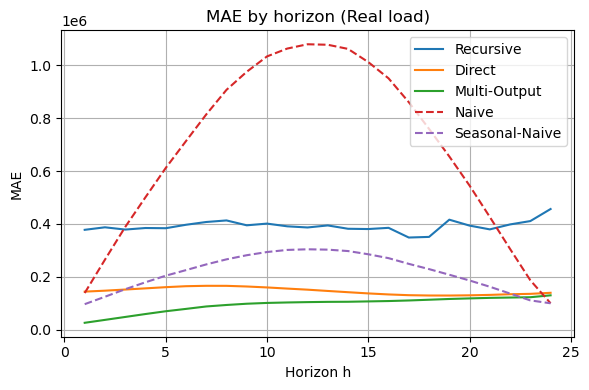

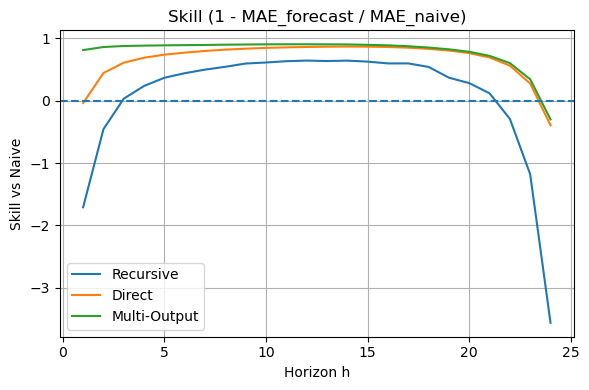

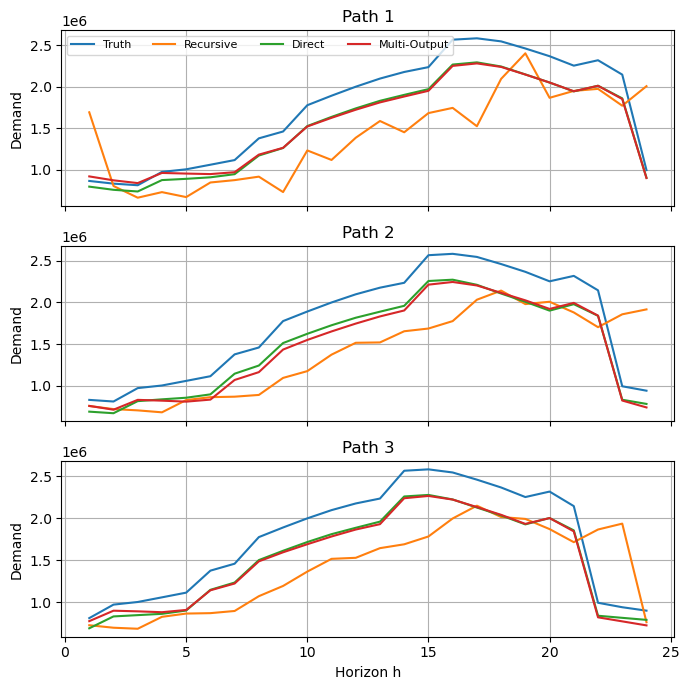

In [13]:
# ------------------------------------------------------------
# Plot 1: Horizon-wise MAE comparison
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
# Plot MAE for each forecasting strategy and baselines
plt.plot(mae_df["h"], mae_df["Recursive"], label="Recursive")
plt.plot(mae_df["h"], mae_df["Direct"], label="Direct")
plt.plot(mae_df["h"], mae_df["Multi-Output"], label="Multi-Output")
plt.plot(mae_df["h"], mae_df["Naive"], label="Naive", linestyle="--")
plt.plot(mae_df["h"], mae_df["Seasonal-Naive"], label="Seasonal-Naive", linestyle="--")

# Label axes
plt.xlabel("Horizon h")          # horizon step (1 to H)
plt.ylabel("MAE")                # Mean Absolute Error
plt.title("MAE by horizon (Real load)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 2: Horizon-wise Skill vs Naive baseline
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
# Plot Skill for each model relative to Naive
plt.plot(skill_df["h"], skill_df["Skill vs Naive (Recursive)"], label="Recursive")
plt.plot(skill_df["h"], skill_df["Skill vs Naive (Direct)"], label="Direct")
plt.plot(skill_df["h"], skill_df["Skill vs Naive (Multi-Output)"], label="Multi-Output")

# Add horizontal line at 0 (baseline performance)
plt.axhline(0.0, linestyle="--")

# Label axes
plt.xlabel("Horizon h")
plt.ylabel("Skill vs Naive")
plt.title("Skill (1 - MAE_forecast / MAE_naive)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 3: Example forecast paths vs Truth
# ------------------------------------------------------------
n_show = 3   # number of test paths to show
fig, axes = plt.subplots(n_show, 1, figsize=(7, 7), sharex=True)

for i in range(n_show):
    # True future demand path
    axes[i].plot(np.arange(1, H+1), Y_test_true[i], label="Truth")
    # Forecasts from the three strategies
    axes[i].plot(np.arange(1, H+1), Y_rec[i], label="Recursive")
    axes[i].plot(np.arange(1, H+1), Y_dir[i], label="Direct")
    axes[i].plot(np.arange(1, H+1), Y_mo[i],  label="Multi-Output")

    # Axis labels and title for each subplot
    axes[i].set_ylabel("Demand")
    axes[i].set_title(f"Path {i+1}")

# Common x-label for the last subplot
axes[-1].set_xlabel("Horizon h")

# Put legend in the first subplot, compact layout
axes[0].legend(ncol=4, fontsize=8)

plt.tight_layout()
plt.show()

## 8) Notes / Potential improvements

- The recursive strategy here omits exogenous temperature at inference; for best practice,
  add a temperature *forecast* or carry forward temperature in a consistent way.
- Try stronger models (e.g., HGBR, Lasso/ElasticNet, RandomForest, XGBoost) under the same split.
- Add rolling k-fold cross-validation for robust horizon-wise metrics.
- Consider richer calendar features (week-of-year, holiday flags).